# ***1. DEPENDENCIES***

In [1]:
# ==============================================================================
# SECTION 1: SETUP AND DEPENDENCIES (UNCHANGED)
# ==============================================================================

# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("TensorFlow version:", tf.__version__)
print("Optuna version:", optuna.__version__)

C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.15.1
Optuna version: 4.5.0


# ***2. Multiclass model Synthetic Balanced data***

## 2.1. Data loading and pre processing (Split Train 70% Test 30%)

In [2]:

# Print the TensorFlow version to confirm installation
print("TensorFlow version:", tf.__version__)

# Read the combined CSV file into a pandas DataFrame
file_path = "VirtualPatientModels_dfFinal_qDate.csv"
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please check the file path.")
    exit()

# Display all columns without truncation for better viewing
pd.set_option('display.max_columns', None)
display(df.head())
print("\nDataFrame Information:")
df.info()

# Exclude irrelevant columns before pre-processing
# We keep 'part_id' for the data split, and remove the others.
cols_to_exclude_from_features = ['clinical_visit', 'q_date']
df = df.drop(columns=cols_to_exclude_from_features, errors='ignore')

# Identify numerical, categorical, and boolean columns to process
numerical_cols = ['bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist']

categorical_cols = ['comorbidities_count',
                    'comorbidities_most_important',
                    'iadl_grade',
                    'social_phone',
                    'life_quality',
                    'age',
                    'low_physical_activity',
                    'ortho_hypotension',
                    'gender',
                    'health_rate_comparison',
                    'comorbidities_significant_count',
                    'social_calls',
                    'depression_total_score',
                    'sleep',
                    'house_suitable_participant',
                    'balance_single',
                    'weight_loss',
                    'stairs_number',
                    'memory_complain',
                    'living_alone',
                    'alcohol_units',
                    'leisure_out',
                    'social_text',
                    'house_suitable_professional',
                    #'health_rate',
                    'hospitalization_three_years',
                    'health_rate']	

boolean_cols = ['gait_optional_binary']

columns_to_encode = categorical_cols + boolean_cols

## One-Hot Encoding
print("\nPerforming one-hot encoding on categorical and boolean columns...")
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode, dtype=int)
print("DataFrame after one-hot encoding:")
display(df.head())

## Normalize Numerical Columns (Min-Max Scaling)
print("\nStatistics before normalization:")
print(df[numerical_cols].describe())

def normalize(df, cols):
    """Applies Min-Max normalization to specified columns."""
    for col in cols:
        if col not in df.columns:
            print(f"[WARNING] {col} not found in DataFrame.")
            continue
        if df[col].max() != df[col].min():
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

df = normalize(df, numerical_cols)

print("\nStatistics after normalization:")
print(df[numerical_cols].describe())

# Save the pre-processed data to be used in the next script
output_file = 'Processed_Real_Data_OMC_Final_Dis.csv'
df.to_csv(output_file, index=False)
print(f"\nProcessed DataFrame saved to '{output_file}'")

TensorFlow version: 2.15.1
'VirtualPatientModels_dfFinal_qDate.csv' loaded successfully.


,part_id,clinical_visit,bmi_score,gait_get_up,bmi_body_fat,raise_chair_time,waist,leisure_out,balance_single,stairs_number,gender,sleep,house_suitable_professional,alcohol_units,comorbidities_most_important,memory_complain,house_suitable_participant,social_calls,comorbidities_significant_count,depression_total_score,weight_loss,gait_optional_binary,hospitalization_three_years,iadl_grade,living_alone,life_quality,age,social_phone,health_rate,q_date,comorbidities_count,low_physical_activity,health_rate_comparison,social_text,ortho_hypotension
0,1084,1,24.095500,9.05,22.8,14.00,89.0,7,>5 sec,17.0,M,No sleep problem,Yes,1.5,Non of the above,No,Yes,7,2,2,No,False,0,29,No,6.8,78,180,4 - Good,2016-10-05T22:52:28.000Z,6,No,3 - About the same,0,No
1,1084,2,24.205693,10.30,23.7,13.46,89.0,7,>5 sec,17.0,M,No sleep problem,Yes,21.0,Non of the above,No,Yes,7,0,2,No,False,0,25,No,7.2,79,70,4 - Good,2017-07-20T00:00:00.000Z,7,No,3 - About the same,20,No
2,1084,3,24.576145,9.40,23.2,13.40,89.0,7,>5 sec,0.0,M,No sleep problem,Yes,14.0,Non of the above,No,Yes,4,0,2,No,False,0,24,No,6.5,79,120,4 - Good,2017-12-01T00:00:00.000Z,7,No,3 - About the same,5,No
3,1084,4,24.836407,9.20,23.2,14.10,89.0,8,>5 sec,0.0,M,Occasional sleep problem,Yes,18.0,Non of the above,No,Yes,5,0,3,No,False,0,26,No,6.9,80,120,4 - Good,2018-09-24T00:00:00.000Z,8,No,3 - About the same,0,No
4,1085,1,23.437500,9.80,26.8,16.00,96.0,7,>5 sec,12.0,F,Occasional sleep problem,Yes,0.0,Non of the above,Yes,Yes,7,1,2,No,False,3,31,No,7.3,72,6,4 - Good,2016-10-10T15:04:04.000Z,11,No,3 - About the same,15,No



DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   part_id                          117 non-null    int64  
 1   clinical_visit                   117 non-null    int64  
 2   bmi_score                        117 non-null    float64
 3   gait_get_up                      117 non-null    float64
 4   bmi_body_fat                     117 non-null    float64
 5   raise_chair_time                 117 non-null    float64
 6   waist                            117 non-null    float64
 7   leisure_out                      117 non-null    int64  
 8   balance_single                   117 non-null    object 
 9   stairs_number                    117 non-null    float64
 10  gender                           117 non-null    object 
 11  sleep                            117 non-null    object 
 12

,part_id,bmi_score,gait_get_up,bmi_body_fat,raise_chair_time,waist,comorbidities_count_0,comorbidities_count_1,comorbidities_count_2,comorbidities_count_3,comorbidities_count_4,comorbidities_count_5,comorbidities_count_6,comorbidities_count_7,comorbidities_count_8,comorbidities_count_9,comorbidities_count_10,comorbidities_count_11,comorbidities_count_12,comorbidities_count_13,comorbidities_count_14,comorbidities_count_15,comorbidities_most_important_MCI,comorbidities_most_important_Non of the above,comorbidities_most_important_Osteoporosis if woman /Osteoarthritis if man,comorbidities_most_important_Prior stroke,iadl_grade_19,iadl_grade_20,iadl_grade_21,iadl_grade_22,iadl_grade_23,iadl_grade_24,iadl_grade_25,iadl_grade_26,iadl_grade_27,iadl_grade_28,iadl_grade_29,iadl_grade_30,iadl_grade_31,social_phone_3,social_phone_5,social_phone_6,social_phone_7,social_phone_10,social_phone_14,social_phone_15,social_phone_20,social_phone_21,social_phone_25,social_phone_30,social_phone_35,social_phone_40,social_phone_45,social_phone_50,social_phone_60,social_phone_70,social_phone_75,social_phone_80,social_phone_90,social_phone_120,social_phone_140,social_phone_180,social_phone_200,social_phone_210,social_phone_240,social_phone_250,social_phone_300,social_phone_315,social_phone_360,social_phone_400,social_phone_420,social_phone_480,social_phone_500,social_phone_540,social_phone_560,social_phone_600,social_phone_660,social_phone_700,social_phone_999,social_phone_1200,social_phone_1260,social_phone_2000,life_quality_2.0,life_quality_3.7,life_quality_4.3,life_quality_4.5,life_quality_5.0,life_quality_5.4,life_quality_5.8,life_quality_5.9,life_quality_6.1,life_quality_6.5,life_quality_6.8,life_quality_6.9,life_quality_7.0,life_quality_7.2,life_quality_7.3,life_quality_7.4,life_quality_7.5,life_quality_7.7,life_quality_7.8,life_quality_8.0,life_quality_8.1,life_quality_8.2,life_quality_8.3,life_quality_8.4,life_quality_8.5,life_quality_8.6,life_quality_8.7,life_quality_8.8,life_quality_9.0,life_quality_9.2,life_quality_9.3,life_quality_9.4,life_quality_9.7,life_quality_10.0,age_70,age_71,age_72,age_73,age_74,age_75,age_76,age_77,age_78,age_79,age_80,age_81,age_82,age_83,age_84,age_85,low_physical_activity_No,low_physical_activity_Yes,ortho_hypotension_No,ortho_hypotension_Yes,gender_F,gender_M,health_rate_comparison_2 - A little worse,health_rate_comparison_3 - About the same,health_rate_comparison_4 - A little better,health_rate_comparison_5 - A lot better,comorbidities_significant_count_0,comorbidities_significant_count_1,comorbidities_significant_count_2,social_calls_1,social_calls_3,social_calls_4,social_calls_5,social_calls_6,social_calls_7,social_calls_8,social_calls_10,social_calls_12,social_calls_14,social_calls_15,social_calls_20,social_calls_25,social_calls_30,social_calls_40,social_calls_50,social_calls_70,depression_total_score_0,depression_total_score_1,depression_total_score_2,depression_total_score_3,depression_total_score_4,depression_total_score_5,depression_total_score_6,depression_total_score_7,depression_total_score_8,sleep_No sleep problem,sleep_Occasional sleep problem,sleep_Permanent sleep problem,house_suitable_participant_No,house_suitable_participant_Yes,balance_single_<5 sec,balance_single_>5 sec,balance_single_test non realizable,weight_loss_No,weight_loss_Yes,stairs_number_0.0,stairs_number_2.0,stairs_number_4.0,stairs_number_5.0,stairs_number_12.0,stairs_number_17.0,stairs_number_19.0,memory_complain_No,memory_complain_Yes,living_alone_No,living_alone_Yes,alcohol_units_0.0,alcohol_units_1.0,alcohol_units_1.5,alcohol_units_2.0,alcohol_units_3.0,alcohol_units_4.0,alcohol_units_4.5,alcohol_units_5.0,alcohol_units_6.0,alcohol_units_12.0,alcohol_units_14.0,alcohol_units_18.0,alcohol_units_20.0,alcohol_units_21.0,alcohol_units_63.0,leisure_out_2,leisure_out_3,leisure_out_4,leisure_out_5,leisure_out_6,leisure_out_7,leisure_out_8,leisure_out_10,leisure_out_12,leisure_out_14,leisure_out_20,social_text_0,social_text_1,social_t


Statistics before normalization:
        bmi_score  gait_get_up  bmi_body_fat  raise_chair_time       waist
count  117.000000   117.000000    117.000000        117.000000  117.000000
mean    28.664850    10.438462     27.653424         45.400684  100.065527
std      5.187214     5.016272      4.306102        180.208977   11.537067
min     22.479339     4.000000     19.700000          6.900000   82.000000
25%     24.744350     7.430000     23.600000          9.690000   94.000000
50%     27.168115     9.050000     27.962651         11.700000   97.000000
75%     29.788797    11.800000     30.550000         14.000000  107.000000
max     44.658044    34.700000     37.200000        999.000000  134.000000

Statistics after normalization:
        bmi_score  gait_get_up  bmi_body_fat  raise_chair_time       waist
count  117.000000   117.000000    117.000000        117.000000  117.000000
mean     0.278894     0.209722      0.454481          0.038807    0.347414
std      0.233883     0.163396   

In [3]:


# ==============================================================================
# SECTION 2: DATA LOADING AND PRE-PROCESSING (MODIFIED Test Set 3)
# ==============================================================================

print("\n" + "="*80)
print("STARTING MULTICLASS CLASSIFICATION (70% SYNTHETIC TRAIN / 30% SYNTHETIC TEST)")
print("="*80 + "\n")

# Reload processed data from the previous script
output_file = 'Processed_Real_Data_OMC_Final_Dis.csv'
try:
    df = pd.read_csv(output_file)
    print(f"'{output_file}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{output_file}' not found. Please run the first script to generate the file.")
    exit()

# --- Data Separation ---
df_original = df[df['part_id'] < 3000].copy() 
df_synthetic_full = df[df['part_id'] >= 3000].copy() 

target_columns = [col for col in df.columns if col.startswith('health_rate_') and not col.startswith('health_rate_comparison_')]

# Add class column for stratification
df_original['health_rate_class'] = df_original[target_columns].idxmax(axis=1)


# ----------------------------------------------------------------------------------
#  TRAINING/TEST LOGIC: 70/30 Stratified Split of REAL Data (MODIFIED) <<< CHANGE
# ----------------------------------------------------------------------------------
TRAIN_FRACTION = 0.7
TEST_FRACTION = 0.3 

# Use StratifiedShuffleSplit on the REAL Data (df_original) <<< CHANGE
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_FRACTION, random_state=42)

for train_index, test_index in sss.split(df_original, df_original['health_rate_class']): # <<< CHANGE: using df_original
    # df_train becomes 70% of the REAL data
    df_train = df_original.iloc[train_index].copy()
    # df_test_real_all becomes the remaining 30% of the REAL data
    df_test_real_all = df_original.iloc[test_index].copy() # <<< CHANGE: Defines the real test set

# Drop the helper column from the final train set
df_train = df_train.drop(columns=['health_rate_class'])


# ----------------------------------------------------------------------------------
#  TEST SETS DEFINITION (Only keeping the Real Test Set) (MODIFIED) <<< CHANGE
# ----------------------------------------------------------------------------------

# Test Set 1: Real Test Data (30% Split from SSS above) - Primary test set

# Test Set 2 (Synthetic) and Test Set 3 (Combined) are not used for this evaluation.
# Previous logic for Test Set 2 and 3 REMOVED
df_test_synthetic = pd.DataFrame() # <<< CHANGE
df_test_combined = pd.DataFrame() # <<< CHANGE

# --- Final Cleanup ---
# Drop the helper column from the test set
df_test_real_all = df_test_real_all.drop(columns=['health_rate_class']) # <<< CHANGE


print("\n" + "-"*40)
print("FINAL DATASET SHAPES (70% REAL TRAIN / 30% REAL TEST)") # <<< CHANGE
print("-" * 40)
print(f"Final training data shape (70% Real): {df_train.shape}") # <<< CHANGE
print(f"Test Set 1 (Real Test Data) shape: {df_test_real_all.shape}") # <<< CHANGE
print(f"Test Set 2 (Synthetic ONLY) shape: {df_test_synthetic.shape}")
print(f"Test Set 3 (Combined Test Data) shape: {df_test_combined.shape}")
print("-" * 40 + "\n")


STARTING MULTICLASS CLASSIFICATION (70% SYNTHETIC TRAIN / 30% SYNTHETIC TEST)

'Processed_Real_Data_OMC_Final_Dis.csv' loaded successfully.

----------------------------------------
FINAL DATASET SHAPES (70% REAL TRAIN / 30% REAL TEST)
----------------------------------------
Final training data shape (70% Real): (81, 245)
Test Set 1 (Real Test Data) shape: (36, 245)
Test Set 2 (Synthetic ONLY) shape: (0, 0)
Test Set 3 (Combined Test Data) shape: (0, 0)
----------------------------------------



# 2.2. Feature/Label Extraction (Encoder)

In [4]:

# --- Feature/Label Extraction for ALL Sets ---
feature_columns = df.columns.drop(target_columns + ['part_id'])
x_train = df_train[feature_columns].values
y_train_df = df_train[target_columns].idxmax(axis=1)

# Test Set 1: All Real Data
x_test_real_all = df_test_real_all[feature_columns].values
y_test_real_all_df = df_test_real_all[target_columns].idxmax(axis=1)

# Set the other test variables to empty/None to avoid later errors <<< CHANGE
x_test_synthetic = np.array([])
y_test_synthetic_df = pd.Series([], dtype='object')
x_test_combined = np.array([])
y_test_combined_df = pd.Series([], dtype='object')


# --- LabelEncoder Setup (CRUCIAL FIX: Ensures all 5 classes are known) <<< CHANGE
TRUE_CLASS_LABELS = [col for col in target_columns] # Use the actual 5 one-hot column names

le = LabelEncoder()
# Fit the encoder on ALL expected labels (5 classes)
le.fit(TRUE_CLASS_LABELS) 

# Transform the labels using the now fully-fitted encoder
y_train = le.transform(y_train_df)
y_test_real_all = le.transform(y_test_real_all_df)

# Assign empty arrays for the unused test sets to avoid errors later
y_test_synthetic = np.array([])
y_test_combined = np.array([])

num_classes = len(le.classes_)

# ***3. Optuna function*** 

In [5]:

# ==============================================================================
# SECTION 3: OPTUNA OBJECTIVE FUNCTION 
# ==============================================================================

def objective(trial):
    """
    Defines the model, hyperparameters to optimize, and returns validation accuracy.
    """
    n_layers = 3 
    n_neurons = trial.suggest_int('n_neurons', 16, 128, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True) 
    patience = trial.suggest_int('patience', 10, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']) 
    
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(n_neurons // 2, activation='relu'))
    model.add(Dense(n_neurons // 4, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else: 
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        x_train,
        y_train,
        epochs=1500,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    best_val_accuracy = max(history.history['val_accuracy'])
    return best_val_accuracy





## 3.1 Run Optuna and get best params (Layers fixed to 3 and 20 Trials)

In [6]:
# ==============================================================================
# SECTION 4: RUN OPTUNA STUDY AND RETRAIN MODEL (UNCHANGED)
# ==============================================================================
#'''
print("\n" + "="*80)
print("STARTING OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*80 + "\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND BY OPTUNA")
print("="*80 + "\n")
best_params = study.best_params
best_params['n_layers'] = 3
print(best_params)
#'''

[I 2025-11-13 16:30:25,198] A new study created in memory with name: no-name-d26d2713-b4cb-48cd-bcf9-5ec083e4b8e0



STARTING OPTUNA HYPERPARAMETER OPTIMIZATION






[I 2025-11-13 16:30:28,796] Trial 0 finished with value: 0.7058823704719543 and parameters: {'n_neurons': 18, 'learning_rate': 0.0015677585150921107, 'patience': 24, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7058823704719543.
[I 2025-11-13 16:30:31,551] Trial 1 finished with value: 0.6470588445663452 and parameters: {'n_neurons': 110, 'learning_rate': 0.0010073601136667467, 'patience': 31, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7058823704719543.
[I 2025-11-13 16:30:33,577] Trial 2 finished with value: 0.6470588445663452 and parameters: {'n_neurons': 18, 'learning_rate': 0.008769815908396473, 'patience': 18, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7058823704719543.
[I 2025-11-13 16:30:35,913] Trial 3 finished with value: 0.6470588445663452 and parameters: {'n_neurons': 18, 'learning_rate': 0.003262641504774219, 'patience': 25, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7058823704719543.
[I 2025-11-13 16:30:42,318] Trial 4 finished wit


BEST HYPERPARAMETERS FOUND BY OPTUNA

{'n_neurons': 18, 'learning_rate': 0.0015677585150921107, 'patience': 24, 'optimizer': 'RMSprop', 'n_layers': 3}


# ***4. Train the model*** 

In [7]:
#best_params = {'n_neurons': 68, 'learning_rate': 0.0004086533702465893, 'patience': 30, 'optimizer': 'Adam', 'n_layers': 3}

In [8]:
# --- Retrain Final Model ---
best_model = Sequential()
best_model.add(Dense(best_params['n_neurons'], input_dim=x_train.shape[1], activation='relu'))
best_model.add(Dense(best_params['n_neurons'] // 2, activation='relu'))
best_model.add(Dense(best_params['n_neurons'] // 4, activation='relu'))
best_model.add(Dense(num_classes, activation='softmax'))

if best_params['optimizer'] == 'Adam':
    best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
else: 
    best_optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(loss='sparse_categorical_crossentropy', optimizer=best_optimizer, metrics=['accuracy'])
best_early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)

print("\nTraining final model with best hyperparameters...")
best_model.fit(
    x_train,
    y_train,
    epochs=2000, 
    validation_split=0.2,
    callbacks=[best_early_stopping],
    verbose=1
)



Training final model with best hyperparameters...
Epoch 1/2000
2/2 [==============================] - 1s 220ms/step - loss: 1.5591 - accuracy: 0.3906 - val_loss: 1.4317 - val_accuracy: 0.4118
Epoch 2/2000
2/2 [==============================] - 0s 45ms/step - loss: 1.4781 - accuracy: 0.4844 - val_loss: 1.3795 - val_accuracy: 0.6471
Epoch 3/2000
2/2 [==============================] - 0s 54ms/step - loss: 1.4227 - accuracy: 0.5625 - val_loss: 1.3355 - val_accuracy: 0.6471
Epoch 4/2000
2/2 [==============================] - 0s 43ms/step - loss: 1.3732 - accuracy: 0.5938 - val_loss: 1.2930 - val_accuracy: 0.6471
Epoch 5/2000
2/2 [==============================] - 0s 42ms/step - loss: 1.3252 - accuracy: 0.5938 - val_loss: 1.2567 - val_accuracy: 0.6471
Epoch 6/2000
2/2 [==============================] - 0s 42ms/step - loss: 1.2867 - accuracy: 0.5938 - val_loss: 1.2264 - val_accuracy: 0.6471
Epoch 7/2000
2/2 [==============================] - 0s 41ms/step - loss: 1.2455 - accuracy: 0.5938 - v

# ***5. Evaluation Results***

In [9]:


# ==============================================================================
# SECTION 5: SINGLE EVALUATION AND PLOTTING (MODIFIED) <<< CHANGE
# ==============================================================================

# Helper function to calculate and print metrics and return confusion matrix
def calculate_and_print_metrics(x_data, y_true, set_name):
    # Added check for empty array to skip evaluation if data set is empty
    if len(y_true) == 0: # <<< CHANGE
        print(f"\n--- {set_name} Metrics ---")
        print("Data set is empty, skipping evaluation.")
        return np.zeros((num_classes, num_classes)) # <<< CHANGE: Return zero matrix

    y_pred = np.argmax(best_model.predict(x_data), axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    # zero_division=0 handles cases where a class is entirely missing in the test set
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0) 
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n--- {set_name} Metrics (Size: {len(y_true)}) ---")
    print(f'Accuracy: {np.round(acc * 100, 2)}%')
    print(f'Precision (Macro): {np.round(precision_macro * 100, 2)}%')
    print(f'Recall (Macro): {np.round(recall_macro * 100, 2)}%')
    print(f'F1-score (Macro): {np.round(f1_macro * 100, 2)}%')
    print(f'Precision (Weighted): {np.round(precision_weighted * 100, 2)}%')
    print(f'Recall (Weighted): {np.round(recall_weighted * 100, 2)}%')
    print(f'F1-score (Weighted): {np.round(f1_weighted * 100, 2)}%')
    
    conf_mat = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({set_name} - Raw Counts):")
    print(conf_mat)
    
    return conf_mat


FINAL PERFORMANCE METRICS COMPARISON (REAL TEST SET ONLY)
2/2 [==============================] - 0s 4ms/step

--- 1. Real Test Data (30% Split) Metrics (Size: 36) ---
Accuracy: 61.11%
Precision (Macro): 12.22%
Recall (Macro): 20.0%
F1-score (Macro): 15.17%
Precision (Weighted): 37.35%
Recall (Weighted): 61.11%
F1-score (Weighted): 46.36%

Confusion Matrix (1. Real Test Data (30% Split) - Raw Counts):
[[ 0  0  0  1  0]
 [ 0  0  0  2  0]
 [ 0  0  0  9  0]
 [ 0  0  0 22  0]
 [ 0  0  0  2  0]]


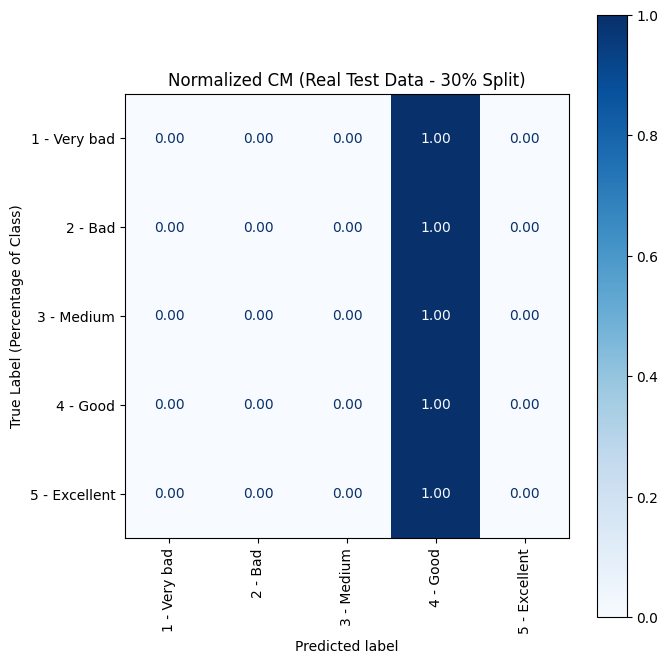

In [10]:
print("\n" + "="*80)
print("FINAL PERFORMANCE METRICS COMPARISON (REAL TEST SET ONLY)") # <<< CHANGE
print("="*80)

# --- Test 1: Real Test Data (30% split) ---
conf_mat_real_all = calculate_and_print_metrics(x_test_real_all, y_test_real_all, "1. Real Test Data (30% Split)")
# REMOVED calls for Test 2 and Test 3 metrics <<< REMOVED

# Calculate Normalized Confusion Matrix (Only for the Real Test Set)
conf_mat_real_all_norm = np.where(conf_mat_real_all.sum(axis=1)[:, np.newaxis] > 0, 
                                  conf_mat_real_all.astype('float') / conf_mat_real_all.sum(axis=1)[:, np.newaxis], 
                                  0)

# --- Single Confusion Matrix Plotting ---
# Use the classes from the fitted LabelEncoder
clabels_full = le.classes_
# Clean up labels for display (remove 'health_rate_')
clabels_display = [c.replace('health_rate_', '') for c in clabels_full] # <<< CHANGE


plt.figure(figsize=(7, 7)) 

# Plot 1: Real Test Data
cm_display_1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_real_all_norm, display_labels=clabels_display) # <<< CHANGE
cm_display_1.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('Normalized CM (Real Test Data - 30% Split)')
plt.ylabel('True Label (Percentage of Class)') 

plt.tight_layout()
plt.show()